In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os

from script.curate_training_test_data import  curate_training_test_data_many
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[df_all['Date'] > pd.to_datetime('2020-12-06')].reset_index(drop=True)

In [ ]:
from script.generate_lstm_pytorch_multistep import *
import torch 

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
devide = 'cuda:1'

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean','High_price', 'Low_price']
test_date = '2018-08-01'

sequence_length = 28

original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values
last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=False,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = False,
                                        )

checkpoint_path = "best_multistep_lstm_____.pth"
# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
model = generate_lstm_multi_step(X_train_tensor, y_train_tensor, device)
if os.path.isfile(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
else:
    history = train_lstm_multi_step(model, checkpoint_path, 
                                    X_train_tensor, y_train_tensor, 
                                    patience=100,
                                    batch_size=16, epochs=100, verbose=0)


c:\Users\DELL\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/500, Train Loss: 0.41529864385540105, Val Loss: 0.08706262111663818
flag == 0 | new best model is saved
Epoch 2/500, Train Loss: 0.17331516926671253, Val Loss: 0.07939992547035217
flag == 1 | new best model is saved
Epoch 3/500, Train Loss: 0.15009869230382236, Val Loss: 0.07884521260857583
flag == 2 | new best model is saved
Epoch 4/500, Train Loss: 0.12422737120478242, Val Loss: 0.0668981708586216
flag == 3 | new best model is saved
Epoch 6/500, Train Loss: 0.10051726692436654, Val Loss: 0.05187801644206047
flag == 4 | new best model is saved
Epoch 37/500, Train Loss: 0.03625588611136248, Val Loss: 0.047028320282697676
Epoch 51/500, Train Loss: 0.028644058117528022, Val Loss: 0.07352778911590577
flag == 5 | new best model is saved
Epoch 69/500, Train Loss: 0.021556575311186873, Val Loss: 0.04309533312916756
flag == 6 | new best model is saved
Epoch 85/500, Train Loss: 0.01752261128736499, Val Loss: 0.03873459510505199
Epoch 101/500, Train Loss: 0.01578045335172871, Val Loss: 

KeyboardInterrupt: 

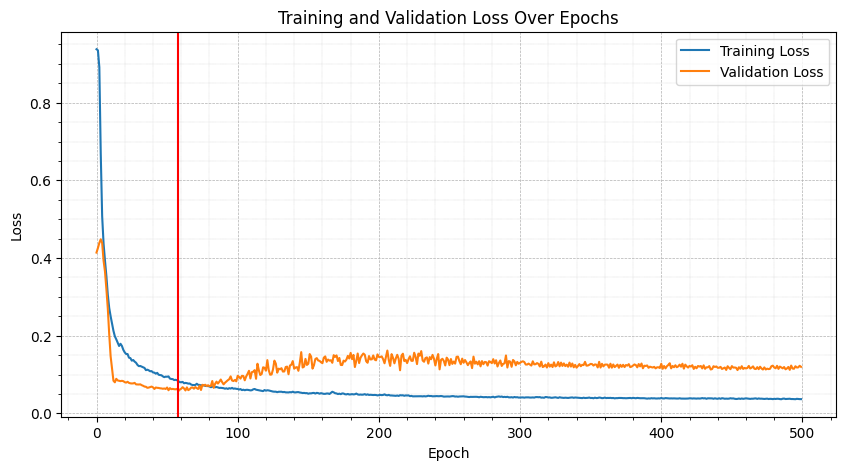

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim([0,100])
plt.title('Training and Validation Loss Over Epochs')
a = np.array(history['val_loss'])
plt.axvline(np.where(a == a.min())[0][0], color = 'red')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.3)

# plt.yscale('log')
plt.legend()
plt.show()


In [8]:
model.load_state_dict(torch.load(checkpoint_path))

C:\Users\DELL\AppData\Local\Temp\ipykernel_52648\3851766659.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


<All keys matched successfully>

In [9]:
# prediction for train/validation data
train_size = int((1 - 0.05) * X_train_tensor.size(0))
y_train_true, y_test_true = y_train[:train_size], y_train[train_size:]

model.eval()
y_train_pred = model(X_train_tensor[:train_size]).detach().cpu().numpy()
y_test_pred = model(X_train_tensor[train_size:]).detach().cpu().numpy()

y_test_preds = []
model.train()
for i in range(10):
    y_test_preds.append(model(X_train_tensor[train_size:]).detach().cpu().numpy())

In [10]:
from script.post_processing import inverse_scaler_of_all_var
y_train_pred = inverse_scaler_of_all_var(y_train_pred, scaler)
y_test_pred  = inverse_scaler_of_all_var(y_test_pred, scaler)
y_test_preds = inverse_scaler_of_all_var(y_test_preds, scaler)
y_train_true = inverse_scaler_of_all_var(y_train_true, scaler)
y_test_true  = inverse_scaler_of_all_var(y_test_true, scaler)

In [11]:
# define start of train date and valid/train split date
train_start_date =  df_all['Date'][0] + pd.to_timedelta(28, unit = 'day')
train_test_split_date = df_all['Date'][0] + pd.to_timedelta(train_size+28, unit = 'day')

In [12]:
from script.save_permformance import save_perform
model_name ='lstm'
save_perform(model_name, y_train_true, y_train_pred, y_test_true, y_test_pred)

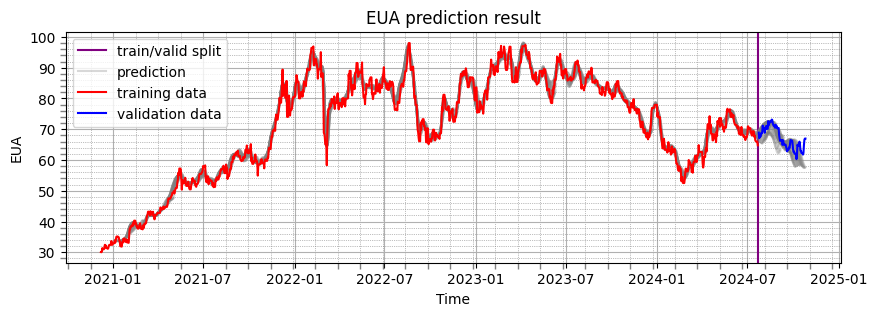

In [13]:
# visuals of train/validation data prediction (single prediction)
from script.post_processing import visual_train_n_valid_data_performance
visual_train_n_valid_data_performance(y_train_pred,y_test_pred, train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})

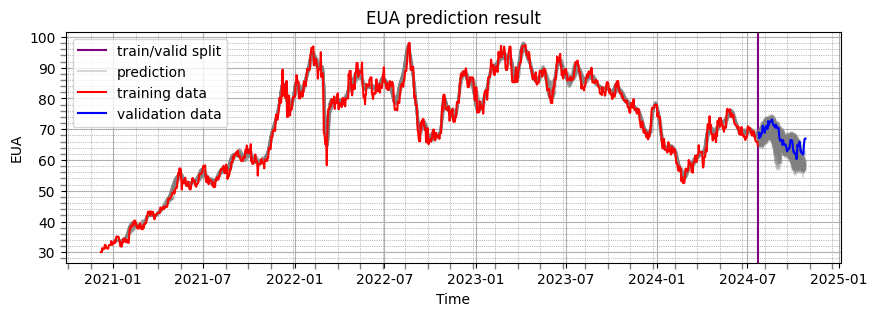

In [14]:
# visual ensemble of predictions
visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                      figsize = (10,3),
                                      index_of_data = 0,
                                      name_of_data = 'EUA',
                                      decoration = {'xlabel': 'Time', 
                                                    'ylabel':'EUA', 
                                                    'title':'EUA prediction result',
                                                    'grid':'on'})

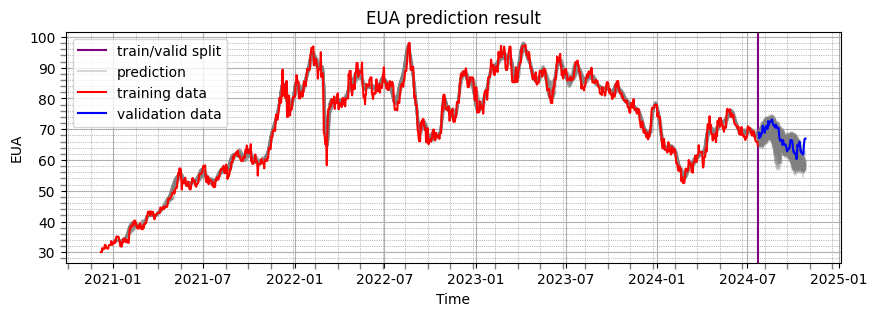

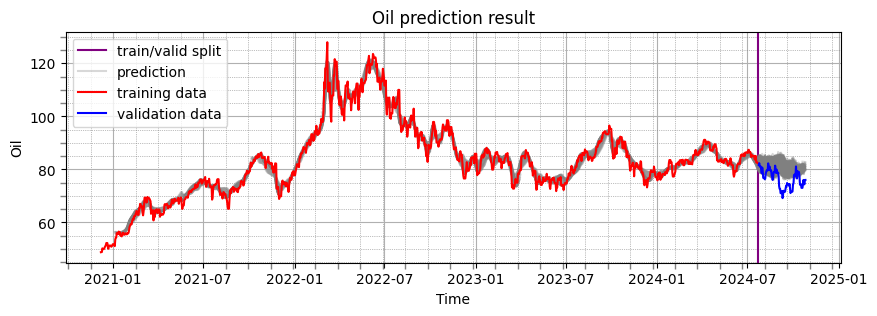

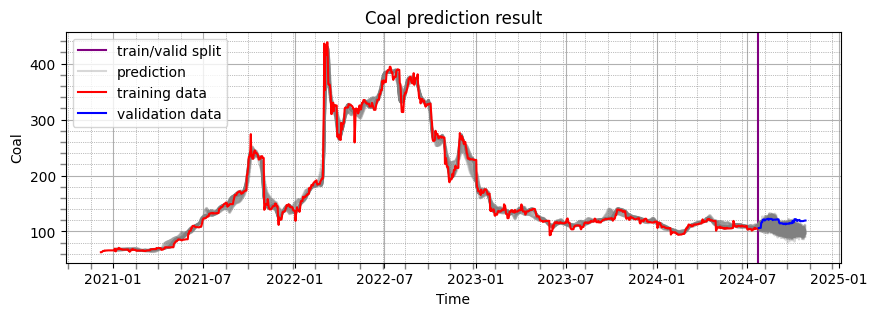

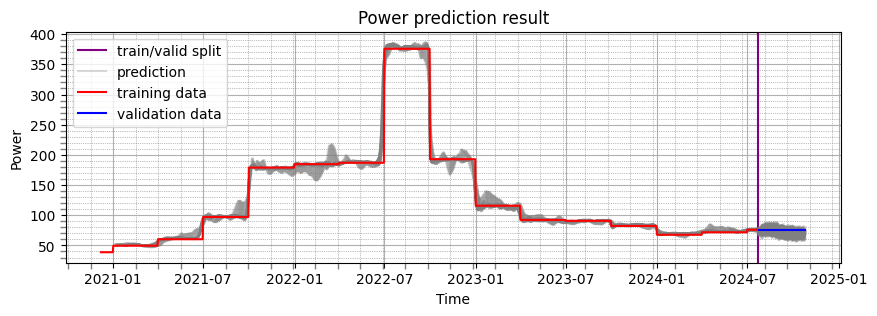

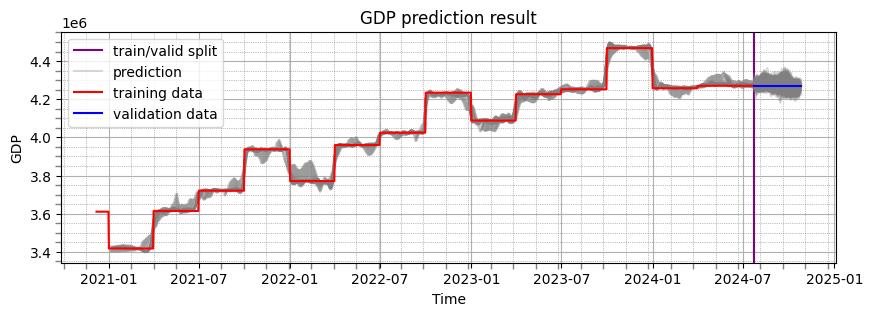

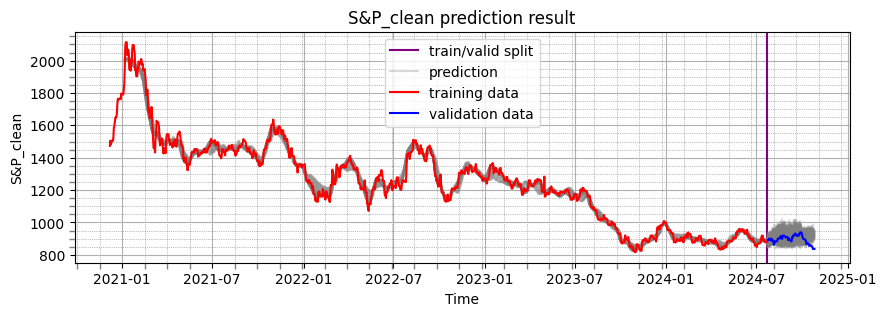

In [15]:
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_train_n_valid_data_performance(y_train_pred,y_test_preds, train_start_date, train_test_split_date, df_all,
                                        figsize = (10,3),
                                        index_of_data = i,
                                        name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})

In [ ]:
from script.generate_lstm_pytorch_multistep import *
import torch 

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean','High_price', 'Low_price']
test_date = '2018-08-01'

folder_name = "result_LSTM_pytorch_multisteps_fin_v10"
if os.path.isdir(folder_name) is not True:
    os.mkdir(folder_name)
modeltype = 'lstm_gpu_v3_fin'
sequence_length = 28

original_EUA = df_all['EUA'].values  
dates = df_all['Date'].values
last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                            df_all, 
                                            flatten=False,
                                            sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                            sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                            test_date=test_date,
                                            predictors_lst=predictors_lst,
                                            dtype = 'float32',
                                            is_test_split = False,
                                        )

checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.pth"
# Convert to PyTorch tensor
X_train_tensor, y_train_tensor = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
model = generate_lstm_multi_step(X_train_tensor, y_train_tensor)
if os.path.isfile('best_mutistep_lstm_model_fin.pth'):
    model.load_state_dict(torch.load('best_mutistep_lstm_model_fin.pth'))
else:
    history = train_lstm_multi_step(model, checkpoint_path, 
                                    X_train_tensor, y_train_tensor,
                                    validation_split = 0.001, 
                                    patience=100,
                                    batch_size=128, epochs=100, verbose=0)
    
# with open('lstm_hist.pkl', 'wb') as f:
#     pickle.dump(history,f)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1



flag == 0
Epoch 2/500, Train Loss: 0.07361730612999151, Val Loss: 0.4767390787601471
flag == 1
Epoch 3/500, Train Loss: 0.04788311724820413, Val Loss: 0.47182732820510864
flag == 2
Epoch 4/500, Train Loss: 0.03907545440453143, Val Loss: 0.3634745478630066
flag == 3
Epoch 5/500, Train Loss: 0.030646653953662586, Val Loss: 0.22129537165164948
flag == 4
Epoch 6/500, Train Loss: 0.024467766284942627, Val Loss: 0.17340348660945892
flag == 5
Epoch 7/500, Train Loss: 0.021341061296541827, Val Loss: 0.1034976989030838
flag == 6
Epoch 8/500, Train Loss: 0.018718802731884414, Val Loss: 0.06443053483963013
flag == 7
Epoch 9/500, Train Loss: 0.016974646444163046, Val Loss: 0.06059856340289116
flag == 8
Epoch 10/500, Train Loss: 0.016152357759554523, Val Loss: 0.0569426566362381
flag == 9
Epoch 11/500, Train Loss: 0.01538514167316689, Val Loss: 0.056346338242292404
flag == 10
Epoch 12/500, Train Loss: 0.014822400305881972, Val Loss: 0.053349342197179794
flag == 11
Epoch 13/500, Train Loss: 0.014274

In [ ]:
# model.load_state_dict(torch.load(checkpoint_path))

In [50]:
# 2. add recursive scheme
from script.post_processing import resursive_furture_prediction, resursive_furture_prediction_with_dropout
model.train()
future_price_ensemble, future_time = resursive_furture_prediction_with_dropout(model, X_train_tensor[-1],
                                                         train_test_split_date = df_all['Date'].max(),
                                                         num_of_ensemble = 100,
                                                         scaler = scaler,
                                                         df_all = df_all)

In [51]:
from script.post_processing import visual_recursive_future_prediction, visual_recursive_future_prediction_plotly
visual_recursive_future_prediction_plotly(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          # figsize = (10,3),
                                          index_of_data= 0, # 0 is EUA price
                                          name_of_data = 'EUA',
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':'EUA', 
                                                        'title':'EUA prediction result',
                                                        'grid':'on'})
                                          

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



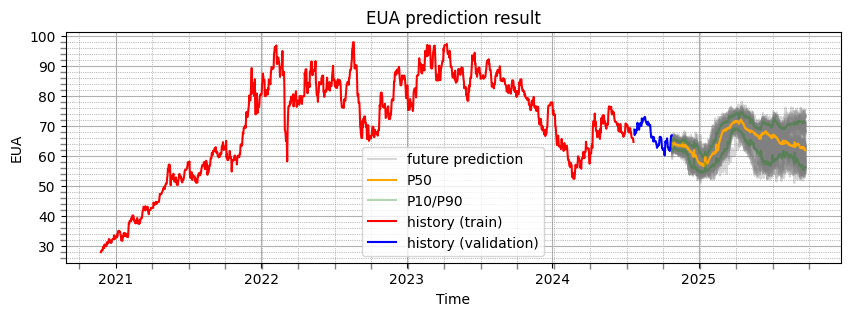

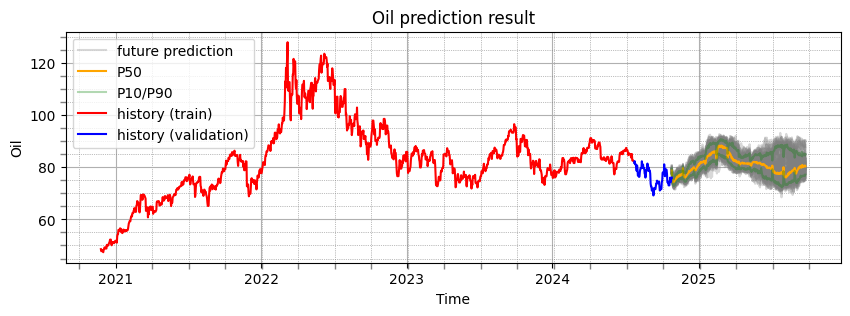

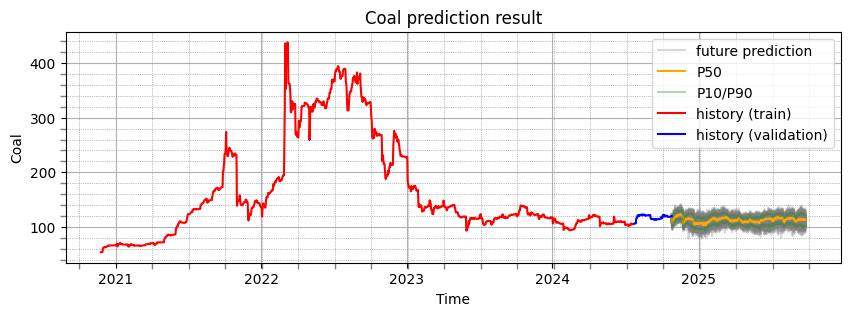

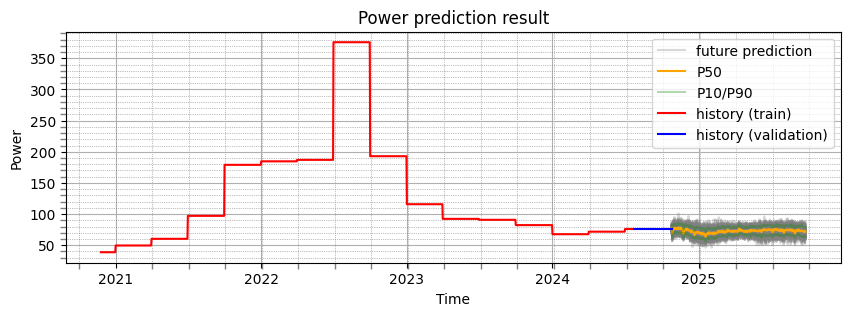

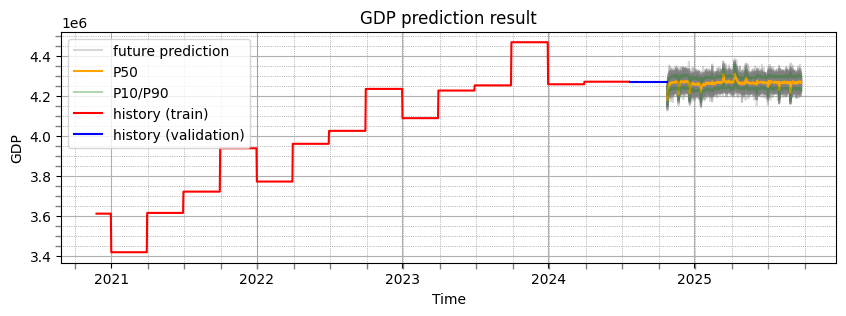

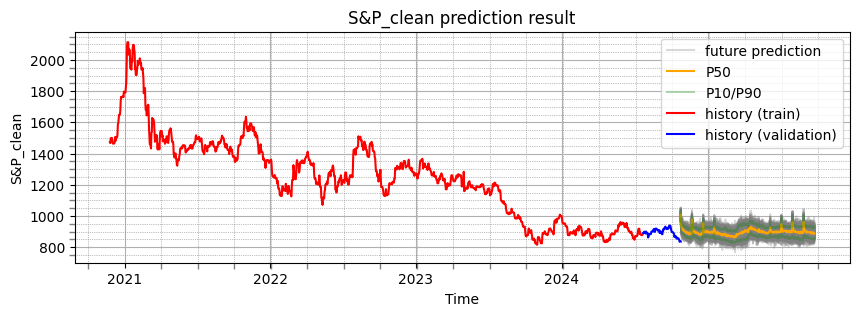

In [52]:
for i, name in enumerate(['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean',]):
    visual_recursive_future_prediction(future_time, future_price_ensemble,
                                       train_test_split_date,
                                       df_all,
                                          figsize = (10,3),
                                          index_of_data= i, # 0 is EUA price
                                          name_of_data = name,
                                        decoration = {'xlabel': 'Time', 
                                                        'ylabel':name, 
                                                        'title':f'{name} prediction result',
                                                        'grid':'on'})
                                          